In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

`df` is an Air Quality dataset containing sensor readings of various pollutants recorded hourly over a period of one year.

missing values, represented by `-200` are replaced by `np.nan`.

In [22]:
df = pd.read_csv("../data/raw_data.csv")

df.replace(-200, np.nan, inplace=True)
df['timestamp'] = pd.to_datetime(df['Date']+' '+df['Time'])
df = df[['timestamp'] + [col for col in df.columns if col != 'timestamp']]

`plot()` is used to visualize the dataframe's columns against the timestamp axis.

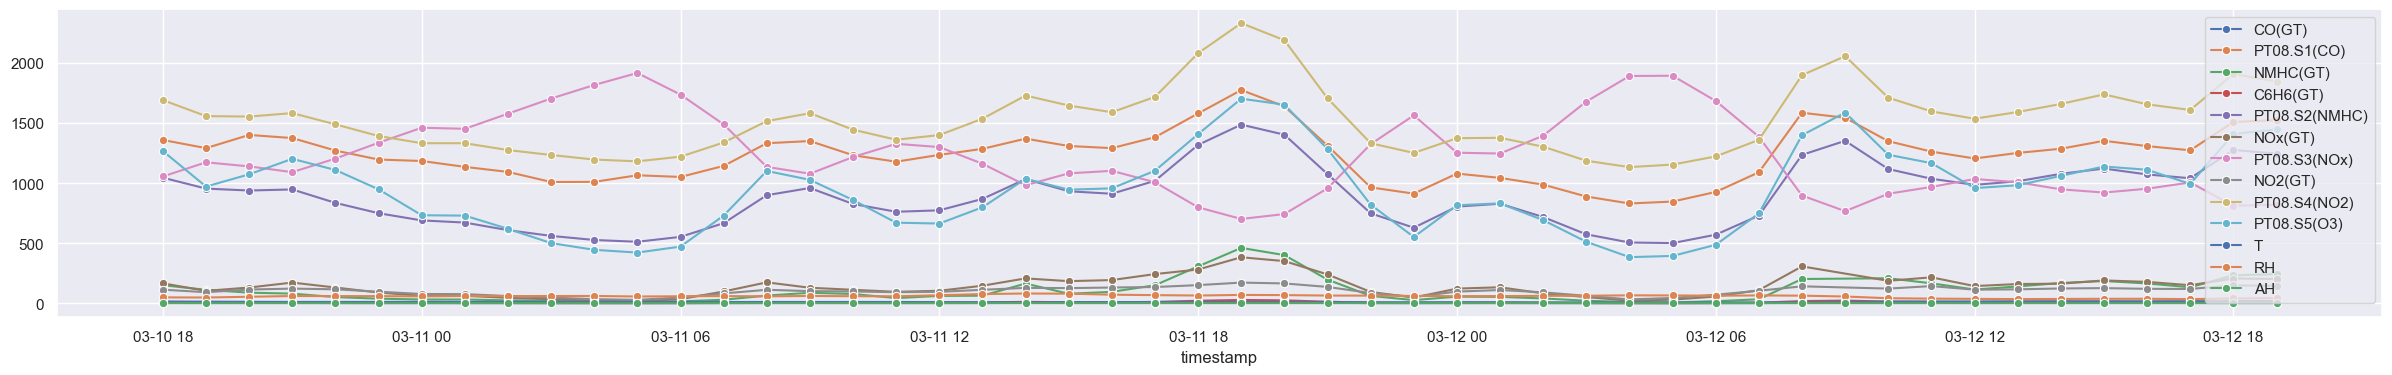

In [23]:
cols = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

def plot(dataframe, title=''): # plots sensor params for given range and df
    plt.figure(figsize=(30, 4))
    sns.set_theme(style="darkgrid")

    for i in cols:
        ax = sns.lineplot(x='timestamp', y=i, data=dataframe, marker='o', label=i,)

    ax.set(ylabel='')
    plt.title(label=title)
    plt.legend(loc="upper right")
    plt.show()

plot(df[:50])

### Handling Missing Values

There are 16701 missing sensor readings. Next, we identify the sensors with the most missing values.

The `NMHC(GT)` sensor has only about one-ninth of its data as valid. It is better to omit this sensor's reading from the dataset. This may lead to a bias while training models.

Imputation Method: kNN - k Nearest Neighbours
There were long gaps of missing sensor readings. Usage of kNN helps preserve the natural trends in the dataset.

In [24]:
df.isnull().sum().sum()

16701

In [25]:
print('missing values:\n')
for i in cols:
    print(f'{ len( df[df[i].isnull()] ) } - {i}')

# it is preferable to exclude the 'NMHC(GT)' sensor reading from the main dataset due to the large number of missing values.
df = df.drop(columns=['NMHC(GT)'])
df[:3]

missing values:

1683 - CO(GT)
366 - PT08.S1(CO)
8443 - NMHC(GT)
366 - C6H6(GT)
366 - PT08.S2(NMHC)
1639 - NOx(GT)
366 - PT08.S3(NOx)
1642 - NO2(GT)
366 - PT08.S4(NO2)
366 - PT08.S5(O3)
366 - T
366 - RH
366 - AH


,timestamp,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,3/10/2004,18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,3/10/2004,19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,3/10/2004,20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502


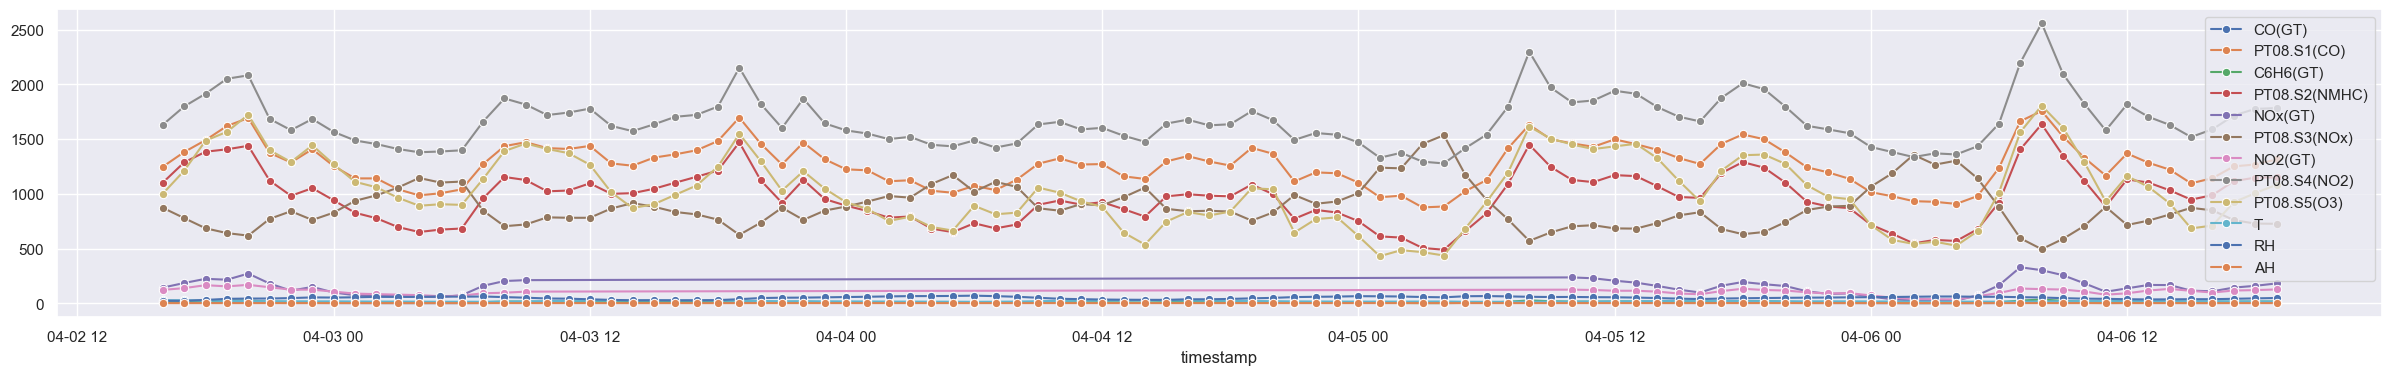

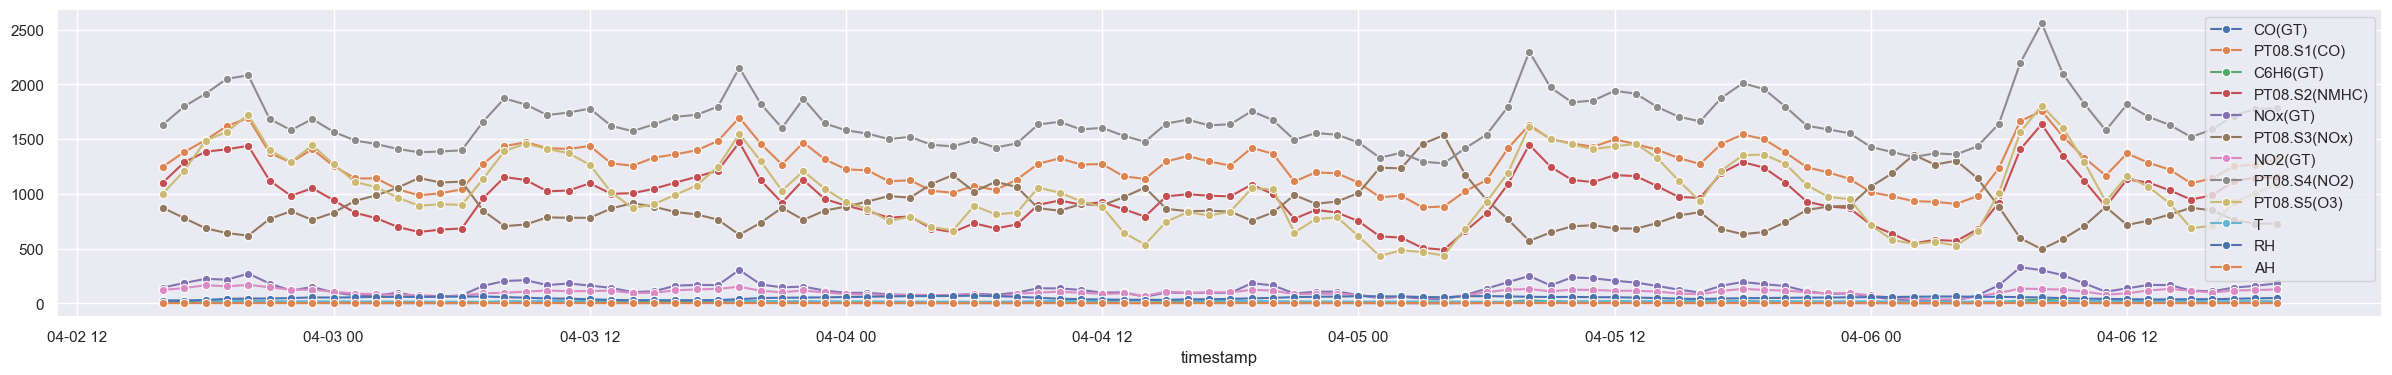

In [26]:
# imputation method - kNN

cols = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_imputed = pd.DataFrame(imputer.fit_transform(df[cols]), columns=cols)

for i in df.columns.tolist():
    if i not in cols:
        df_imputed[i] = df[i]

plot(df[550:650])
plot(df_imputed[550:650]) # post imputation

In [27]:
df = df_imputed

### Feature Scaling & Encoding

We use the Standardization Method of Scaling, since the readings from the sensors may not have a ceiling.

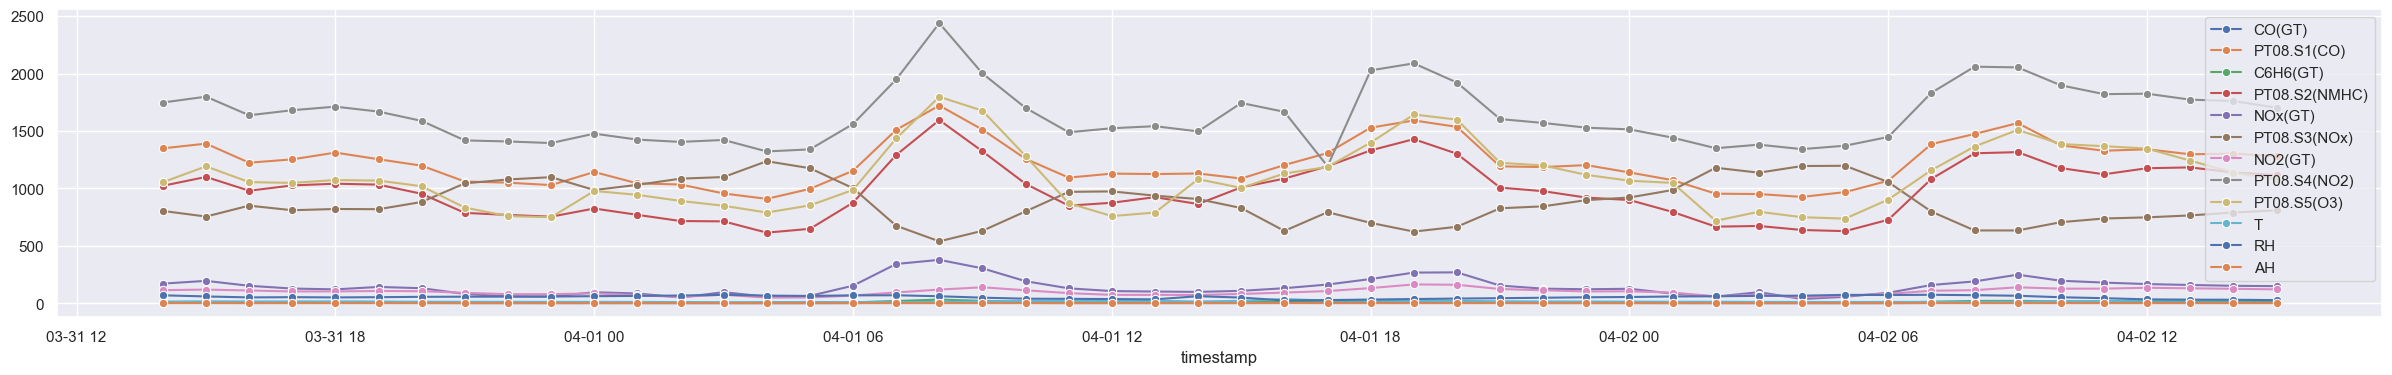

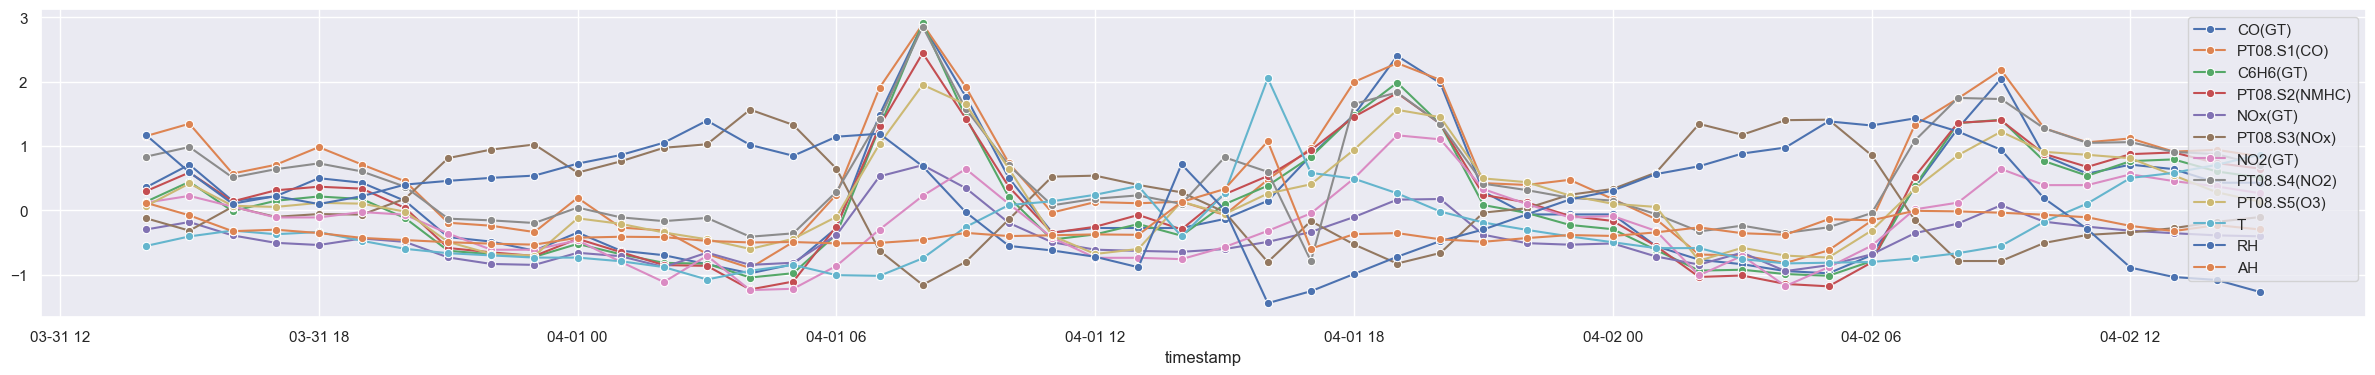

In [28]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed[cols]), columns=cols)

for i in df.columns.tolist():
    if i not in cols:
        df_scaled[i] = df[i]

plot(df[500:550])
plot(df_scaled[500:550]) # post imputation

In [38]:
df = df_scaled

### Time-Based Feature Engineering

We extract the relevant time-based features: hour of the day, day of the week, month of year.

Time-based features help models capture cyclical patterns, seasonal trends, and periodic fluctuations, improving predictions.

In [39]:
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_of_week
df['month'] = df['timestamp'].dt.month

df[:3]

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,timestamp,Date,Time,hour,day_of_week,month
0,0.360781,1.207923,0.231106,0.387916,-0.319143,0.860740,0.101217,0.673254,0.611915,-0.550340,-0.010348,-0.677977,2004-03-10 18:00:00,3/10/2004,18:00:00,18,2,3
1,-0.061306,0.890937,-0.103716,0.046898,-0.623211,1.320955,-0.337869,0.284629,-0.136944,-0.584387,-0.080081,-0.759165,2004-03-10 19:00:00,3/10/2004,19:00:00,19,2,3
2,0.079390,1.403709,-0.157288,-0.013062,-0.488070,1.188350,0.122126,0.272941,0.121109,-0.743275,0.286018,-0.697080,2004-03-10 20:00:00,3/10/2004,20:00:00,20,2,3


We also extract the mean data of each day and week in `day_df` and `week_df` respectively.

In [40]:
day_df1 = df.groupby(df.index // 24)[cols].mean().reset_index(drop=True)
day_df2 = df.groupby(df.index // 24).agg({'timestamp': 'first', 'Date': 'first', 'Time': 'first'}).reset_index(drop=True)

day_df = pd.concat([day_df1, day_df2], axis=1)
# plot(day_df[:100])

In [41]:
week_df1 = df.groupby(df.index // (24*7))[cols].mean().reset_index(drop=True)
week_df2 = df.groupby(df.index // (24*7)).agg({'timestamp': 'first', 'Date': 'first', 'Time': 'first'}).reset_index(drop=True)

week_df = pd.concat([week_df1, week_df2], axis=1)
# plot(week_df)

### Outlier Detection

The IQR - Interquartile Range Method is used to find the outliers in the dataset. Values falling outside `[Q1 - 1.5*IQR, Q3 + 1.5*IQR]` identified as outliers, where `Q3` is the 75th %ile and `Q1` is the 25th %ile.

In [42]:
# finding outliers using IQR

for i in cols:
    q3 = df[i].quantile(0.75)
    q1 = df[i].quantile(0.25)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    l = ''.join(list(df.loc[(df[i] < lower_bound) | (df[i] > upper_bound), 'timestamp'].to_string()))

    print(f"{i}:\n{l}\n")

CO(GT):
25     2004-03-11 19:00:00
26     2004-03-11 20:00:00
50     2004-03-12 20:00:00
98     2004-03-14 20:00:00
110    2004-03-15 08:00:00
111    2004-03-15 09:00:00
112    2004-03-15 10:00:00
120    2004-03-15 18:00:00
121    2004-03-15 19:00:00
122    2004-03-15 20:00:00
159    2004-03-17 09:00:00
169    2004-03-17 19:00:00
170    2004-03-17 20:00:00
171    2004-03-17 21:00:00
183    2004-03-18 09:00:00
207    2004-03-19 09:00:00
518    2004-04-01 08:00:00
529    2004-04-01 19:00:00
554    2004-04-02 20:00:00
638    2004-04-06 08:00:00
697    2004-04-08 19:00:00
864    2004-04-15 18:00:00
865    2004-04-15 19:00:00
866    2004-04-15 20:00:00
887    2004-04-16 17:00:00
889    2004-04-16 19:00:00
890    2004-04-16 20:00:00
974    2004-04-20 08:00:00
998    2004-04-21 08:00:00
1008   2004-04-21 18:00:00
1009   2004-04-21 19:00:00
1033   2004-04-22 19:00:00
1046   2004-04-23 08:00:00
1057   2004-04-23 19:00:00
1165   2004-04-28 07:00:00
1190   2004-04-29 08:00:00
1201   2004-04-29 19

### Exploratory Data Analysis (EDA)

Correlation heatmaps are essential for understanding relationships between different parameters. A value closer to 1 or -1 indicates a strong correlation.

Example: The heatmap allows us to find the strong inverse relation between `PT08.S3(NOx)` and other variables such as `CO(GT)` and `PT08.S1(CO)`.

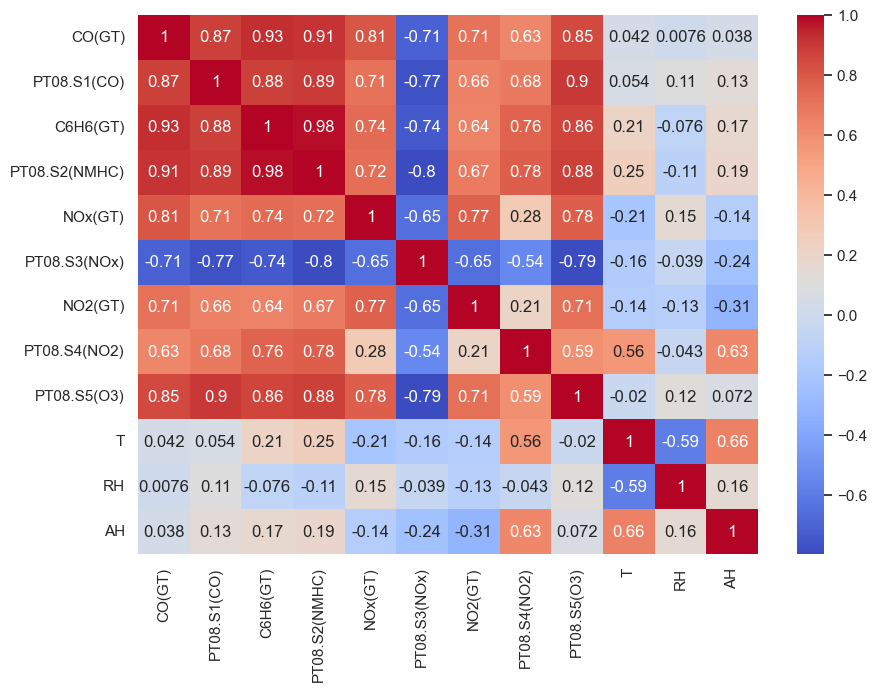

In [43]:
plt.figure(figsize=(10, 7))
sns.heatmap(df[cols].corr(), annot=True, cmap="coolwarm")
plt.show()

Histograms project distribution of datapoints across sensors. Bell Curves are depicted across most sensor readings.

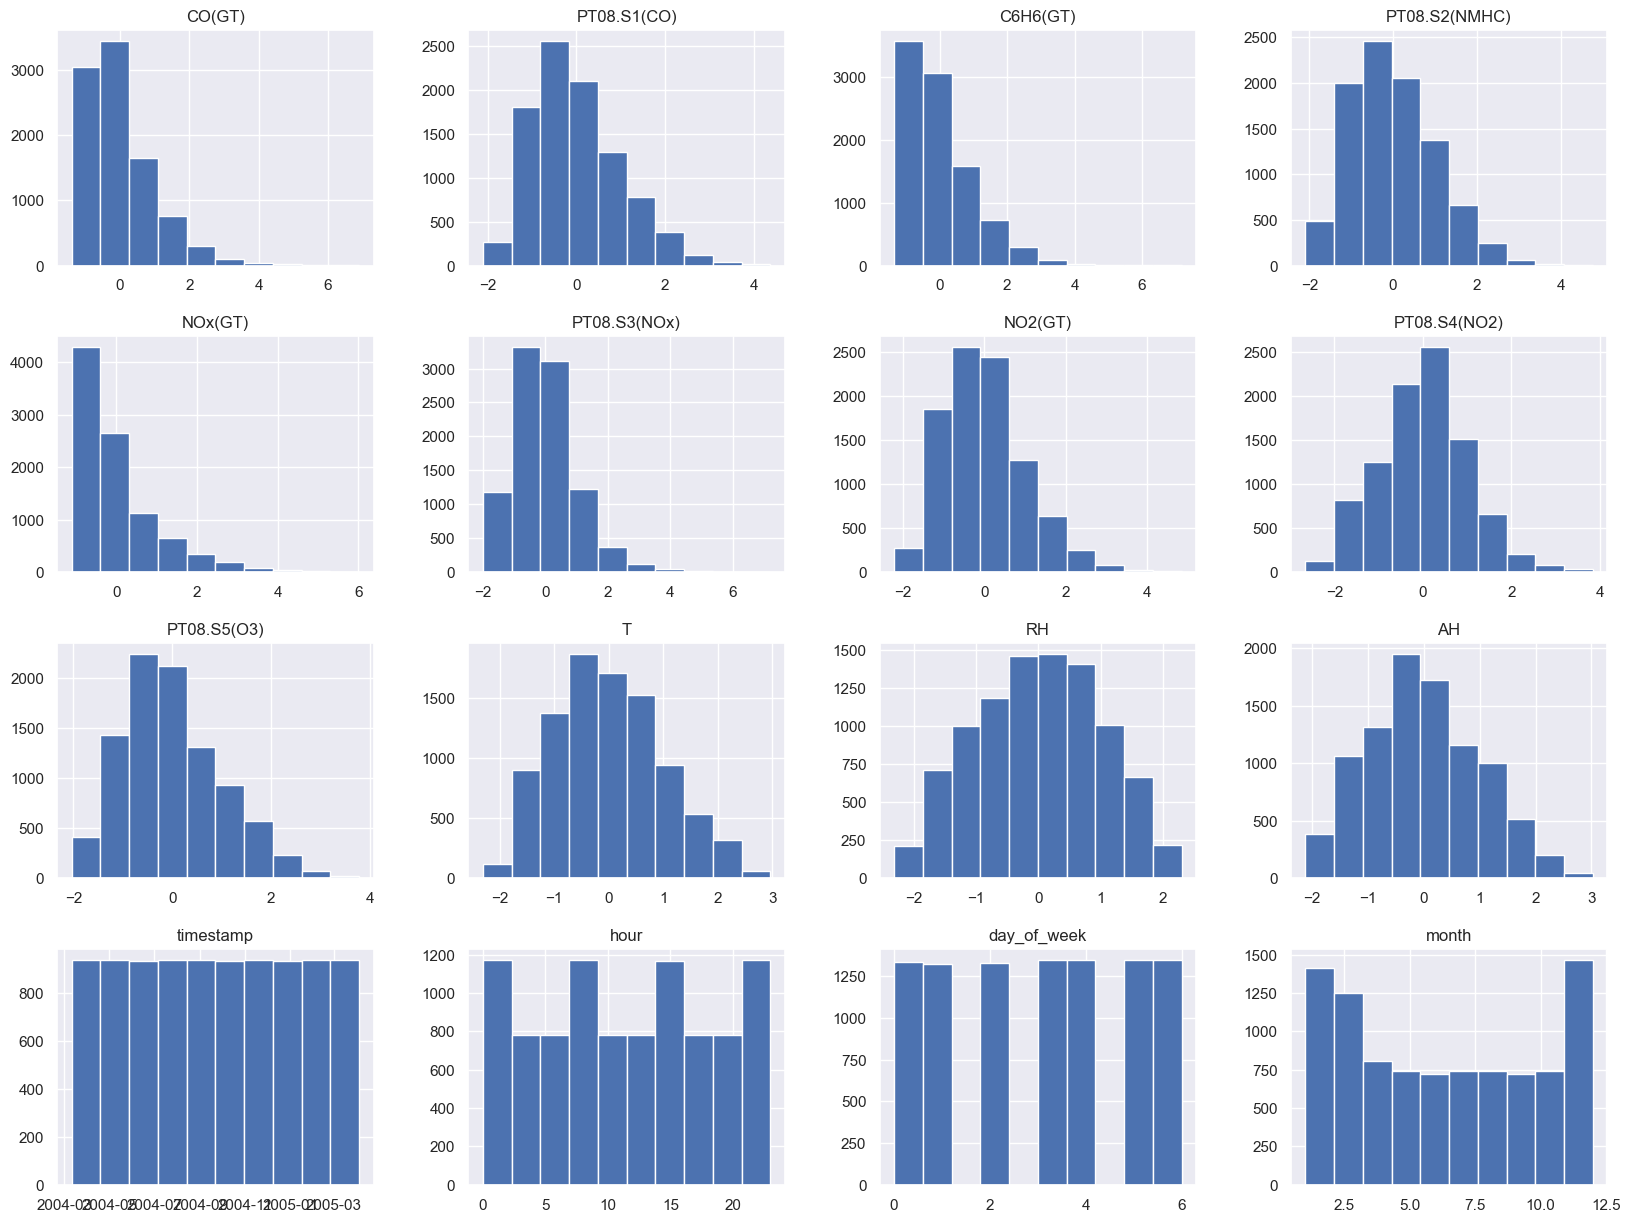

In [ ]:
df.hist(figsize=(20, 15))  # Plots histograms for all numerical features
plt.show()

In [ ]:
df.to_csv('../data/cleaned.csv')